## Import Dependencies and Open Instrument Handles

In [1]:
import sys
import os
import time
import pyvisa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from binascii import unhexlify
import serial
 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\Drivers")

from Driver_PM_PM5020 import *
from Driver_TSL_Goumax import *

In [4]:
rm = pyvisa.ResourceManager()
pm = PM_PM5020()
pm.open(rm)
tsl = TSL_TLS200()
tsl.open(rm)

## Initialization

In [5]:
wavelength_start = 1550
wavelength_stop = 1600
wavelength_step = 0.1
wavelength = np.linspace(wavelength_start,wavelength_stop,int((wavelength_stop-wavelength_start)/wavelength_step)+1)

tsl.set_output_on()
tsl.set_wavelength(wavelength_start)

pm.set_units(1,"dBm")
pm.set_averaging(1,10)

## Measurement Routine (No Acknowledgement)

In [9]:
meas_df = pd.DataFrame()
for i in range(0,len(wavelength)):
    tsl.set_wavelength(wavelength[i])
    time.sleep(0.1)
    power = pm.get_power(1)
    dictionary = {'Wavelength':wavelength[i], 'Power_dBm':power}
    meas_df_temp = pd.DataFrame([dictionary])
    data = [meas_df_temp, meas_df]
    meas_df = pd.concat(data,ignore_index=True,sort=False)   

## Plot and Save Data

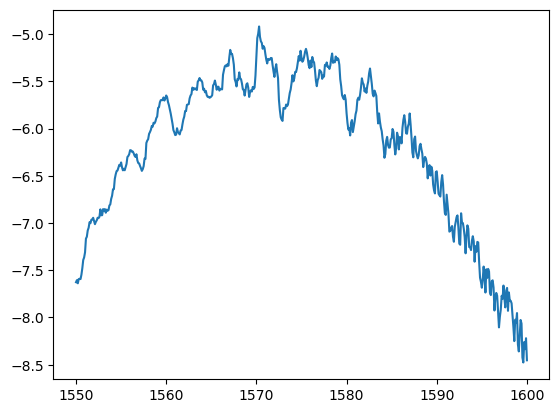

In [10]:
plt.plot(meas_df.Wavelength,meas_df.Power_dBm)
meas_df.to_csv(r"Reference.csv")

## Measurment Routine (With Acknowledgement)

In [7]:
meas_df = pd.DataFrame()
for i in range(0,len(wavelength)):
    wavelength_pm = int(wavelength[i]*1000)
    head = "AA"
    command1 = "474F"
    command2 = "574C"
    msgLength = "0002"
    wavelen_Hex = str(hex(wavelength_pm))[2:].upper()
    command = f"{command1}{command2}{msgLength}{wavelen_Hex}"
    chksum_4chars = tsl.checkSum(command)
    write_frame = f"{head}{command1}{command2}{msgLength}00{wavelen_Hex}{chksum_4chars}"
    messageSetWavelengthHex = unhexlify(write_frame)
    messageSetWavelengthHex += b'\x0D'
    bytesWritten = tsl.tsl.write_raw(messageSetWavelengthHex)
    while(tsl.tsl.read_bytes(4) != b'DONE'):
        pass
    power = pm.get_power(1)
    dictionary = {'Wavelength':wavelength[i], 'Power_dBm':power}
    meas_df_temp = pd.DataFrame([dictionary])
    data = [meas_df_temp, meas_df]
    meas_df = pd.concat(data,ignore_index=True,sort=False)   

VisaIOError: VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.

## Plot and Save Data

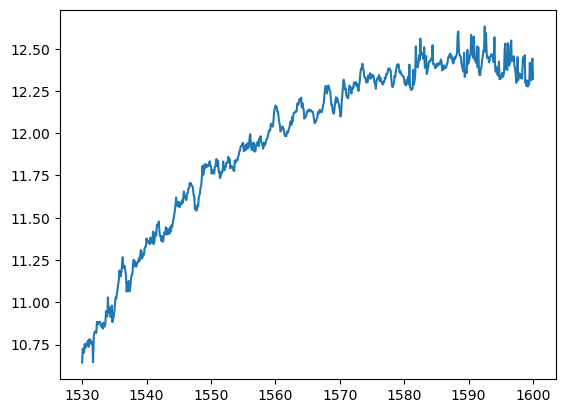

In [100]:
plt.plot(meas_df.Wavelength,meas_df.Power_dBm)
meas_df.to_csv(r"Acknowledgement_based_wavelength_sweep.csv")

## Close Instrument Handles

In [11]:
pm.close()
tsl.close()

In [12]:
tsl.set_output_off()

In [20]:
tsl.set_wavelength(1577)